# First Attempt
batch size 256 lr 1e-3

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


## Options

In [2]:
classTrainFeatures = basic_features
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 10000
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'PRI_tau_pt', 'DER_deltar_tau_lep', 'PRI_jet_leading_eta', 'PRI_lep_eta', 'PRI_tau_eta', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_jet_num', 'PRI_met', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_sum_pt', 'PRI_jet_leading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_met_sumet', 'DER_prodeta_jet_jet', 'PRI_lep_pt', 'PRI_jet_subleading_pt', 'PRI_met_phi', 'PRI_jet_leading_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_tau_phi']


## Import data

In [3]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'val.hdf5', "r+")

## Determine LR

In [ ]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,0.1], trainOnWeights=False, verbose=0)

In [4]:
compileArgs['lr'] = 1e-2

## Train classifier

Using cosine annealing
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.39851850825
3 New best found: 0.378018053281
6 New best found: 0.373818654954
7 New best found: 0.368301386255
13 New best found: 0.365337164784
14 New best found: 0.364040376173
15 New best found: 0.363527067458
Early stopping after 25 epochs
Score is: {'loss': 0.363527067458213, 'AUC': 0.093804270566494319, 'wAUC': 0.070617054910997235}
Fold took 30.280s

Running fold 2 / 10
1 New best found: 0.40529379754
2 New best found: 0.395994098327
3 New best found: 0.378085678487
6 New best found: 0.37376587987
7 New best found: 0.369481371633
13 New best found: 0.368972632719
14 New best found: 0.36600236682
15 New best found: 0.365388717888
Early stopping after 25 epochs
Score is: {'loss': 0.36538871788790478, 'AUC': 0.094921981871856742, 'wAUC': 0.07021224619373001}
Fold took 24.919s

Running fold 3 / 10
1 New best found: 0.407930535074
2 New best found: 0.397183059487
3 New best found: 

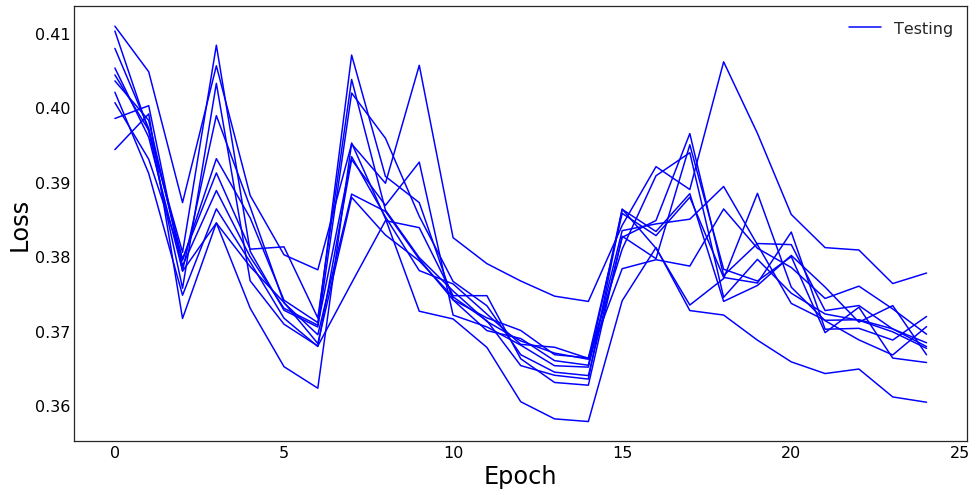

Mean wAUC = 0.0709 +- 0.0006
______________________________________



In [5]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, cosAnnealMult=2, trainOnWeights=False, maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on development data

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

In [ ]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', testData), getFeature('pred', testData)),
                                                           roc_auc_score(getFeature('targets', testData), getFeature('pred', testData), sample_weight=getFeature('weights', testData)))

## Evaluation

### Import in dataframe

In [ ]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'gen_sample', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['gen_sample'] = getFeature('gen_sample', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [ ]:
devData = convertToDF(trainData)
valData = convertToDF(testData)

In [ ]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### ROC curve

In [ ]:
rocPlot(inData=[devData, valData],
        params=[{'linestyle':'dashed', 'color':'b'}, {'color':'b'}],
        labels=['Train', 'Test'], weightName='gen_weight')

### MVA distributions

In [ ]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [ ]:
getSamplePredPlot(valData)

## Save classified data

In [ ]:
name = dirLoc + signal + "_" + channel + "_" + varSet + '_' + classModel + '_classifiedData.csv'
print "Saving data to", name
valData.to_csv(name, columns=['gen_target', 'gen_weight', 'gen_sample', 'pred_class'])

## Save/load

In [ ]:
name = "weights/DNN_" + signal + "_" + channel + "_" + varSet + '_' + classModel
print name

### Save

In [ ]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=1)

### Load

In [ ]:
ensemble, weights, compileArgs, inputPipe, outputPipe = loadEnsemble(name)